# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
# import quadrotor

# print("Mass    =", quadrotor.MASS)
# print("Length  =", quadrotor.LENGTH)
# print("Inertia =", quadrotor.INERTIA)
# print("Dt      =", quadrotor.DT)
# print("state size   =", quadrotor.DIM_STATE)
# print("control size =", quadrotor.DIM_CONTROL)



## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [2]:
import quadrotor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
%matplotlib inline
# %matplotlib widget
import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
from typing import Tuple, Any
from qpsolvers import Problem, solve_problem
import gc
import qpsolvers
def controller(x,t):
    return np.zeros(2)

# x_init = np.array([0., 0., 0., 0., 0., 0.])
# horizon_length = 10
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)



## Part 1
1. Given State dynamics:
$$\begin{align} 
\dot{p_x} &= v_x\\
\dot{v}_x &= - \frac{(u_1 + u_2) \sin \theta}{m} \\ 
\dot{p_y} &= v_y\\
\dot{v}_y &= \frac{(u_1 + u_2) \cos \theta}{m}  - g\\
\dot{\theta} &= \omega\\
\dot{\omega} &= \frac{r (u_1 - u_2)}{I} \end{align}$$

After Discretizing the state dynamics and doing Taylor Series Expansion to get a linear approximation
$$\begin{align}
    \delta p_{x_{n+1}} &= \delta p_{x_n} + \delta t \delta v_{x_n} \\
    \delta v_{x_{n+1}} &= \delta v_{x_n} - \delta t \delta \theta_n \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - \delta t (\delta u_{1_n} +  \delta u_{2_n} )\frac{\sin \theta_n}{m}\\
    \delta p_{y_{n+1}} &= \delta p_{y_n} + \delta t \delta v_{y_n} \\
    \delta v_{y_{n+1}} &= \delta v_{y_n} - \delta t \delta \theta_n \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} + \delta t (\delta u_{1_n} + \delta u_{2_n}) \frac{\cos \theta_n}{m}\\
    \delta \theta_{n+1} &= \delta \theta_{n} + \delta t \delta \omega_n \\
    \delta \omega_{n+1} &= \delta \omega_{n} + \delta t \frac{L(\delta u_{1_n} - \delta u_{2_n})}{I}
\end{align}$$

In [3]:
class Optimization:
    def __init__(self, m, l, I, dt, g, xdim, udim):
        self.m = m
        self.l = l
        self.I = I
        self.dt = dt
        self.g = g
        self.xdim = xdim
        self.udim = udim

    def quadrotor_dynamics(self, x_init, y, N=100):
        nvar = self.xdim + self.udim
        # Print the shapes
        # print(f"Total shape of y: {y.shape}")
        # print(f"Total shape of x_init: {x_init.shape}")
        y = y.flatten()
        x_init = x_init.flatten()

        # Define the placeholders for A and b
        A = np.zeros((6 * N, nvar * N))
        b = np.zeros(6 * N)

        # Define the initial state constraints
        A[:6, :] = np.eye(6, nvar * N)
        b[:6] = x_init - y[:6]

        # Define the constraints for the rest of the time steps
        for t in range(N-1):
            # Propogate the indices
            i = t * nvar
            n = i
            n1 = i + nvar

            # Assign the variables at time step t
            px = y[n]
            vx = y[n + 1]
            py = y[n + 2]
            vy = y[n + 3]
            theta = y[n + 4]
            omega = y[n + 5]
            u1 = y[n + 6]
            u2 = y[n + 7]

            # Assign the variables at time step t+1
            px_1 = y[n1]
            vx_1 = y[n1 + 1]
            py_1 = y[n1 + 2]
            vy_1 = y[n1 + 3]
            theta_1 = y[n1 + 4]
            omega_1 = y[n1 + 5]

            # Position x constraint
            A[6 * (t+1), n] = 1
            A[6 * (t+1), n + 1] = self.dt
            A[6 * (t+1), n1] = -1
            b[6 * (t+1)] = px + (self.dt * vx) - px_1

            # Velocity x constraint
            A[6 * (t+1) + 1, n + 1] = 1
            A[6 * (t+1) + 1, n + 4] = -self.dt * ((u1 + u2) * np.cos(theta) / self.m)
            A[6 * (t+1) + 1, n + 6] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n + 7] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n1 + 1] = -1
            b[6 * (t+1) + 1] = vx - (self.dt * (u1 + u2) * np.sin(theta) / self.m) - vx_1

            # Position y constraint
            A[6 * (t+1) + 2, n + 2] = 1
            A[6 * (t+1) + 2, n + 3] = self.dt
            A[6 * (t+1) + 2, n1 + 2] = -1
            b[6 * (t+1) + 2] = py + self.dt * vy - py_1
            
            # Velocity y constraint
            A[6 * (t+1) + 3, n + 3] = 1
            A[6 * (t+1) + 3, n + 4] = -self.dt * ((u1 + u2) * np.sin(theta) / self.m)
            A[6 * (t+1) + 3, n + 6] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n + 7] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n1 + 3] = -1
            b[6 * (t+1) + 3] = vy + self.dt * (((u1 + u2) * np.cos(theta) / self.m) - 9.81) - vy_1

            # Angle theta constraint
            A[6 * (t+1) + 4, n + 4] = 1
            A[6 * (t+1) + 4, n + 5] = self.dt
            A[6 * (t+1) + 4, n1 + 4] = -1
            b[6 * (t+1) + 4] = theta + self.dt * omega - theta_1

            # Angular velocity omega constraint
            A[6 * (t+1) + 5, n + 5] = 1
            A[6 * (t+1) + 5, n + 6] = self.dt * self.l / self.I
            A[6 * (t+1) + 5, n + 7] = -self.dt * self.l / self.I
            A[6 * (t+1) + 5, n1 + 5] = -1
            b[6 * (t+1) + 5] = omega + self.dt * self.l * (u1 - u2) / self.I - omega_1

        # # Print shapes of A and b
        # print(f"Shape of A: {A.shape}")
        # print(f"Shape of b: {b.shape}")
        return A, b
    
    # def traj_gen(self, k: int, N: int = 100, MAX_Y: int = 3, MAX_X: int = 1) -> Tuple[float, float, float]:
    def traj_gen(self, k, N = 100) -> Tuple[float, float, float]:
        # Orientation cycles every 100 steps
        des_theta = (k / 100) * (2 * np.pi)

        # Repeat k every 100 steps
        k = k % N
        des_y = (1.0 + np.sin(-np.pi/2 + (2 * np.pi * k) / N))*1.5
        des_x = (np.cos(-np.pi/2 + (2 * np.pi * k) / N))

        return des_x, des_y, des_theta

    def QR_cost(self):
        Q = np.diag([30, 0.3, 30, 0.3, 3, 0.3])
        R = np.diag([0.1, 0.1])

        return Q, R
    
    def cost_function(self, y, N, k_init):
        nvar = self.udim + self.xdim
        y = y.flatten()
        Q, R = self.QR_cost()
        P = block_diag(*([block_diag(Q, R)] * N))
        q = np.zeros((nvar * N))
        for k in range(N):
            des_x, des_y, des_theta = self.traj_gen(k=k_init, N=100)
            k_init += 1

            # desired_state = np.array([[des_x], [0], [des_y], [0], [des_theta], [0]])
            q[(k * nvar):(k * nvar) + nvar] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ Q)).flatten(), [0., 0.]))  # Append zeros for control terms

        q = q.reshape(-1, 1)

        # Compute the cost function value
        cost = ((0.5 * (y.T @ P @ y)) + ((2 * q.T) @ y))[0]
        return cost
    
    def grad_cost(self, y, N = 100, k_init = 0) -> np.ndarray:
        nvar = self.udim + self.xdim
        y = y.flatten()
        Q, R = self.QR_cost()
        P = block_diag(*([block_diag(Q, R)] * N))
        q = np.zeros((nvar * N))
        for k in range(N):
            des_x, des_y, des_theta = self.traj_gen(k=k_init, N=100)
            k_init += 1

            # desired_state = np.array([[des_x], [0], [des_y], [0], [des_theta], [0]])
            q[(k * nvar):(k * nvar) + nvar] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ Q)).flatten(), [0., 0.]))  

        # Compute the grad_L of the cost function
        grad_L = P @ y + q
        return grad_L
    

    def hess_cost(self, N=100) -> np.ndarray:
        Q, R = self.QR_cost()
        hess_L = block_diag(*([block_diag(Q, R)] * N))
        return hess_L

    def state_constraints(self, y, N = 100) -> Tuple[np.ndarray, np.ndarray]:
        nvar = self.udim + self.xdim
        y = y.flatten()
        miniG = np.array([
            [0, 0,  0, 0, 0, 0,  0, 0],  
            [0, 0, -1, 0, 0, 0,  0, 0], 
            [0, 0,  0, 0, 0, 0,  1, 0],  
            [0, 0,  0, 0, 0, 0, -1, 0],  
            [0, 0,  0, 0, 0, 0,  0, 1],  
            [0, 0,  0, 0, 0, 0,  0,-1]   
        ])

        G = block_diag(*([miniG] * N))

        h = np.zeros((((self.udim + 1) * 2) * N))

        for i in range(N):
            u_1 = y[(i * nvar) + 6]
            u_2 = y[(i * nvar) + 7]
            h[((6 * i))] = 0  
            h[((6 * i) + 1)] = y[(i * nvar) + 2]  
            h[((6 * i) + 2)] = 10 - u_1  
            h[((6 * i) + 3)] = u_1  
            h[((6 * i) + 4)] = 10 - u_2  
            h[((6 * i) + 5)] = u_2 

        return G, h
    
    def KKT_Solver(self, x_init, y, N=100, k_init=0):
        A, b = self.quadrotor_dynamics(x_init=x_init, y=y, N=N)
        G, h = self.state_constraints(y=y, N=N)

        # Create the QP problem object
        problem = Problem(
            P = csr_matrix(self.hess_cost(N=N)),
            q = self.grad_cost(y=y, N=N, k_init=k_init),
            A=csr_matrix(A),
            b=-b,
            G=csr_matrix(G),
            h=h
        )

        # Print the shapes of the matrices
        # print(f"Shape of P: {problem.P.shape}")
        # print(f"Shape of q: {problem.q.shape}")
        # print(f"Shape of A: {problem.A.shape}")
        # print(f"Shape of b: {problem.b.shape}")
        # print(f"Shape of G: {problem.G.shape}")
        # print(f"Shape of h: {problem.h.shape}")

        # Solve the QP problem using a specified solver
        solution = solve_problem(
            problem=problem,
            solver="cvxopt",  
            initvals=y,  
            tol=1e-4  
        )

        if solution is None:
            print("QP solver failed to find a solution")
        return solution
    
    def constraint_violation(self, x_init, y, N= 100) -> float:
        nvar = self.udim + self.xdim
        y = y.flatten()
        x_init = x_init.flatten()
        A_prime, b_prime = self.quadrotor_dynamics(x_init=x_init, y=y, N=N)
        model_violation = np.sum(np.abs(b_prime))

        # Compute inequality constraint violation
        inequality_violations = 0
        for i in range(N):
            u_1 = y[(i * nvar) + 6]  
            u_2 = y[(i * nvar) + 7] 

            if u_1 > 10:
                inequality_violations += np.abs(10 - u_1)  
            elif u_1 < 0:
                inequality_violations += np.abs(u_1)  
            if u_2 > 10:
                inequality_violations += np.abs(10 - u_2)  
            elif u_2 < 0:
                inequality_violations += np.abs(u_2)  
            if y[(i * nvar) + 2] < 0: 
                inequality_violations += np.abs(y[(i * nvar) + 2])  

        return model_violation + inequality_violations
    
    def line_search(self, x_init, y_est, N, alpha=1.0, rho=0.5, tol=1e-4, iterations=1000, k_init=0):
        nvar = self.udim + self.xdim
        y_est = np.asarray(y_est).flatten()
        x_init = np.asarray(x_init).flatten()

        # Initialize variables for tracking progress
        least_violation = np.inf
        optimal_cost = np.inf
        cost_list = []
        alpha_list = []
        violation_list = []

        # Line search loop
        for i in range(iterations):
            smallville = False

            sol = self.KKT_Solver(x_init=x_init, y=y_est, N=N, k_init=k_init)
            pk = sol.x

            while ((self.cost_function(y=(y_est + (alpha * pk)), N=N, k_init=k_init) >= optimal_cost) and (self.constraint_violation(x_init=x_init, y=(y_est + (alpha * pk)), N=N) >= least_violation)):
                alpha = rho * alpha
                if alpha < 1e-6:
                    smallville = True
                    break

            if smallville:
                break

            # Update
            least_violation = self.constraint_violation(x_init=x_init, y=(y_est + (alpha * pk)), N=N)
            optimal_cost = self.cost_function(y=(y_est + (alpha * pk)), N=N, k_init=k_init)

            alpha_list.append(alpha)
            cost_list.append(optimal_cost)
            violation_list.append(least_violation)

            y_est = y_est + (alpha * pk)
            if least_violation < tol and i != 0:
                break

        y_est = y_est.reshape(-1, nvar)
        x = y_est[:, :6].T
        u = y_est[:, 6:].T

        print(f"Convergence reached at iteration {i+1}.")

        return x, u
    def controller(self, x_init, k_init) -> np.ndarray:
        time_steps = 50
        y_est = np.zeros((self.udim + self.xdim) * time_steps, )
        y_est[:6] = x_init

        try:
            _, u = self.line_search(x_init=x_init,y_est=y_est,N=time_steps,alpha=1.0,rho=0.5,tol=1e-4,iterations=1000,k_init=k_init)
            print(f"for k = {k_init}\n")

        except ValueError as e:
            # Handle optimization failure
            print(f"Optimization failed at time {k_init * quadrotor.DT}: {e}")


        return u[:, 0].flatten()

In [4]:
# Initialize the optimization class
opt = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
N = 100
nvar = quadrotor.DIM_STATE + quadrotor.DIM_CONTROL
# Initialize the variables
x_init = np.array([0., 0., 0., 0., 0., 0.])
x , u = opt.line_search(x_init=x_init, y_est=np.zeros((nvar * N,)), N=N, alpha=1.0, rho=0.5, tol=1e-4, iterations=1000, k_init=0)


Convergence reached at iteration 20.


In [5]:
quadrotor.animate_robot(x, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAaGBtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EThliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8
dV/vzdPNgHyNMPd7Qeurp1KvON9Kpiiq9WLcXgAu6rO4VJF3rAEt8s69kj217dTvtZESV+cTFtXm
3MWiO6d6NaNes2JxyIga8j/MW3CqBIXjhkLWvdScKZvg8MVaqrvYXuPHtXdox+2jtMl6rE9m/6s+
6Cy5TIeNjaXXn1STQyWNTn8r0KGY5XUU8YWj4rZIaUkBqvdT8HuUUf+o5XJ26+3LKiBErocn6j49
qq8oSXOlEJOrVByQ/AJBrvhIWmp7Arh1AuEuWsSZb82qwUX4YpLA+jhMqj8m793/30LpXeFCUvZ2
UCe1W6p2YBPju3XCRbv1SUWh+PCzX/y/JOTn5daKAGqplfjh5srEeY/c4vSTRR95J8M5n4/TGcAx
LQ3PrLHc2GMPnZEJfxoC+wBYhBAypi/Fy9xMI1ucvHymIu5d422tynfquHUyrPs+EoGJWAKSh7sA
/1MVNHQEZn8PVx0E7zdACzSSpOOGTWhaF57lTZmwv25AAm1RWpQZQNAjDBwssbGzn7T9AUYvB5TR
OC2Y81b4lVRo85K9ALdVT88zTm3NQJtghKkRdRSpqhUtIrjCZKMykOlm2t9EO0rQF5ZuCfH/lz+/
UwWvmDPTn9cTK5z3Vxl7LtLEbhh5Vfx71ieysrD8L/9IQmf+q2zFJh7Sh+8YpRuqdP1EIbAeOEuG
IyXAZ8dExE3ggS3C04yJjAgtHFPfwoCk4e5VyD1+YVxVKaQ+yeMF6HGK7M7BdG0++ViQSUecZkcy
q1tCyReJ2zQBZtiL+Q3loxtWdewSaQ+NnVN7fG8qziVfQ55Fst86EHRbfp6enX6l609SVLqc8hcx
f/fCQwUA3xUgn9ALzX/KIqIs204slWYN4Bk3i0PMdv4mAPQ3kYPhLZ2GJFrqmMsOmKKc+fGkIXiC
sZIoKF5Reli6qIvktB/sjAAAAwAAAwJFsjA4IkNwgAA9uSydKQoAAhPDEJrYbP3KymRGga1Uuohm
xKhZH2Yn5lK0WzScL2WGjTB/ekTdy0Qj6v0Vxsxl9IRSLhPGYqw4lo0h9Gy1L577forFFKRxihz6
kzx6/BLo4iiyYv2hjdbN8Wig5xtYr1wGNx0Kh8FGJplZtY3rNX1siz7GbExK2ilgZoY3IvSqyG+r
p3NIYBygdQBY9goi6QL9EqkIaGSrTtqhKxkTDBLEtNZR2edrWma7E3g+yP982UMI29crGN1hqrJI
sAdZcmptAB/sGkdZHVrFakDijr01mm/B0EsNOalG+h85u/Ak7kGkErZkyKVJF8XW70AZzNMtZwL1
QtfiWQHwhfN6dXmoQEfTeK+kUIP3ANaNnTdC91JzUNZqwLf4R16yhZMh9ZtQhGhQwcRlBDO2pR3p
LBBmqzeCT7BmlznobMyN8n/LE+GArszhK7ixOaycMIE4g0AkPrIEpTZtuBkGpBdf/Jbxzq/g3oF6
kAONCoxhfb51FoRhrvXk4xaB7ksAAAMAAEQ4w+4p35p+dyaaOzH/8Saui0dUmCxt38b1y7H+iIb/
5jYUYgIKeWyMANxGu5Bod1NMf1L/nhgRYiJFcLmfnlzwfyZK0Z01SoT4fVQ41i6q7jvOO+PAZoTZ
ydGxxvxYDMFiwuP0tPBxX8BIvBBEX8SeCikdA9j29/yNGHXmp8vnZKOgQ22F0R/VheX941Fa09XP
8ei+xtF3g2kGGrML2KlzyvAbyHK9GX8rfrkZiiea9N9tfFzs361iuP96s/k/fJZNrNbLE3BMM0GB
HWGe2s+ld63mPi1/J2KEBnRT44abvFqHSfpyQpdkMP3DAUMu1wJmK3X1nBkFDnmH8X601O4yugKL
1+BHYJslyVeGJ5kitV2K+uto7gM08uTaKztdYqBLHmjRAh7wU18e5Puxu3ZF4T3ZKulfjxrus+tT
iWmNXJvox4Z7ZxneTQfzdg5ILZcjcd4t4sN+/5x7D7XUuqrhU2ywc+blAfrShULGq0LZ0YNXyFIC
zQicbQ0NnCZtdZo6CS2J79wCZSUyhIEYsvZSp/WAylYaxmnzmtkjqr0Ag3t8vt5VLSJ3Ak/2P8v8
K46DA+hmavHzEPlxCRlsKQ9jQBJPeaT2mr9CGoSOmgwsz6P0jYYVG/8CSwRYVuiKqGJk6TS43hBL
sWFlYUsTfU2+KTZNMn6pH9rvgdzs6iV8P48I7hcwAAADAAANcWa74R92vMeuabzxI/PO9MkpOCi1
cLl1SfMhHfoc8wXeOOhWmbuPMNqsEyAe7SBRzhZnfb6P4L4ympTVb7wKSGIfWmOmInjKra1N2Deb
fE8CqhTU6QXc4YwpU99szgpnNLh8hHQ0sWqTCPrL/Y1zDpATWHCS/4/fj9AJ06zTgTOheeyGhV6V
HbNF9FWMS2l7+R2JcP+LklzPI0XfCH/YyGnSA4w8rpzOv4QNlzRnmvWoOZlpfBQeMN+UBCdcliFH
65qbp6JNz/kBRFD3IQzMN

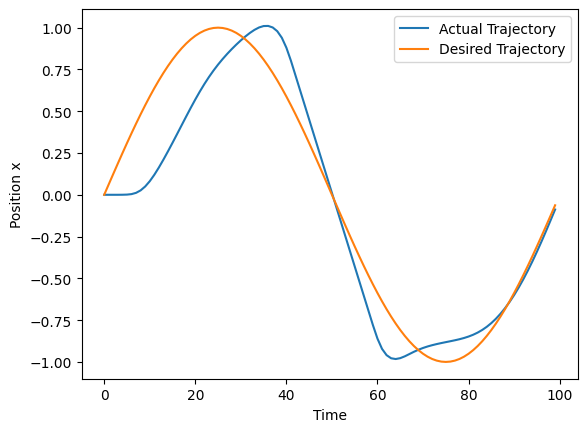

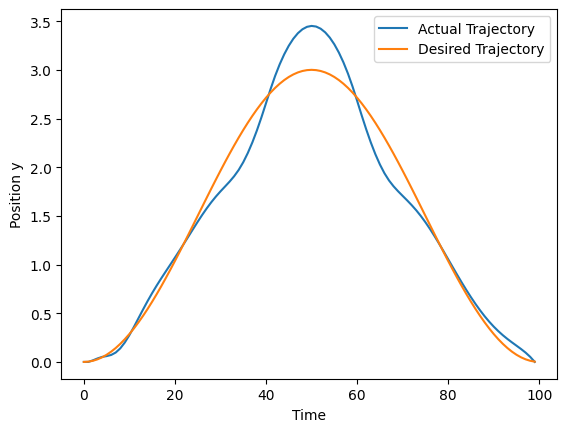

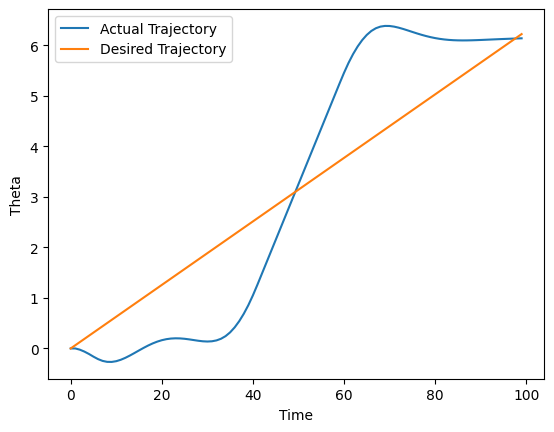

In [6]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.traj_gen(i, N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(x[0, :], label="Actual Trajectory")
plt.plot(x_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(x[2, :], label="Actual Trajectory")
plt.plot(y_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(x[4, :], label="Actual Trajectory")
plt.plot(theta_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()





In [7]:
horizon_length = 300

# Simulate the quadrotor's trajectory
x_init = np.array([0, 0, 0, 0, 0, 0])
t, state, u = quadrotor.simulate(x_init, opt.controller, horizon_length, disturbance=True)

# Animate the quadrotor's trajectory
quadrotor.animate_robot(state, u)

Convergence reached at iteration 11.
for k = 0

Convergence reached at iteration 5.
for k = 1

Convergence reached at iteration 2.
for k = 2

Convergence reached at iteration 2.
for k = 3

Convergence reached at iteration 13.
for k = 4

Convergence reached at iteration 14.
for k = 5

Convergence reached at iteration 14.
for k = 6

Convergence reached at iteration 14.
for k = 7

Convergence reached at iteration 26.
for k = 8

Convergence reached at iteration 28.
for k = 9

Convergence reached at iteration 26.
for k = 10

Convergence reached at iteration 28.
for k = 11

Convergence reached at iteration 33.
for k = 12

Convergence reached at iteration 18.
for k = 13

Convergence reached at iteration 19.
for k = 14

Convergence reached at iteration 18.
for k = 15

Convergence reached at iteration 32.
for k = 16

Convergence reached at iteration 69.
for k = 17

Convergence reached at iteration 34.
for k = 18

Convergence reached at iteration 36.
for k = 19

Convergence reached at iteration 

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAlKJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ERZliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8
dV/vzdPNgHyNMPd7Qeurp1KvON9Kpiiq9WLcXgAu6rO4VJF3rAEt8s69kj217dTvtZESV+cTFtXm
3MWiO6d6NaNes2JxyIga8j/MW3CqBIXjhkLWvdScKZvg8MVaqrvYXuPHtXdox+2jtMl6rE9m/6s+
6Cy5TIeNjaXXn1STQyWNTn8r0KGY5XUU8YWj4rZIaUkBqvdT8HuUUf+o5XJ26+3LKiBErocn6j49
qq8oSXOlEJOrVByQ/AJBrvhIWmp7Arh1AuEuWsSZb82qwUX4YpLA+jhMqj8m793/30LpXeFCUvZ2
UCe1W6p2YBPju3XCRbv1SUWh+PCzX/y/JOTn5daKAGqplfjh5srEeY/c4vSTRR95J8M5n4/TGcAx
LQ3PrLHc2GMPnZEJfxoC+wBYhBAypi/Fy9xMI1ucvHymIu5d422tynfquHUyrPs+EoGJWAKSh7sA
/1MVNHQEZn8PVx0E7zdACzSSpOOGTWhaF57lTZmwv25AAm1RWpQZQNAjDBwssbGzn7T9AUYvB5TR
OC2Y81b4lVRo85K9ALdVT88zTm3NQJtghKkRdRSpqhUtIrjCZKMykOlm2t9EO0rQF5ZuCfH/lz+/
UwWvmDPTn9cTK5z3Vxl7LtLEbhh5Vfx71ieysrD8L/9IQmf+q2zFJh7Sh+8YpRuqdP1EIbAeOEuG
IyXAZ8dExE3ggS3C04yJjAgtHFPfwoCk4e5VyD1+YVxVKaQ+yeMF6HGK7M7BdG0++ViQSUecZkcy
q1tCyReJ2zQBZtiL+Q3loxtWc+jh/MWas0NdOYEDJbtf/rRQ+DoQcZmoKEowijpxLjZPV7DaEUYJ
MPviq33vMHLlCj6SkF9+cwv12+q5s+L7HlYRaJeRiuOP4D+W6VNk7msAXVlfq8gYk/DdPcKs25F0
i9wtiL0tfIiymAKp8hGEFo3WhKj/cGMPiLWxZItGWfnRy/es+9dfmS2qUSK7QiFQaeN4h5zfO8oz
jceIKG1ztiwkJEXzKol7LrBu7T/hTNq89WLAxoiZFQKb8MvETySDt5XTzklt9p7Uvnvt+vai1cfG
ErPqTPHr8EujFuwJq0d+fWY7xW4qJhEWtCjlTG7hDsTw1Ho0wO7nRCiCo3KAMXy6WPGBNmZdx8h0
z3VdO5pDAOcCiALIDl+VRHfc2lvw35SX8NoGrUfczad3kzyjV+1rTNeAxdpZ60YZcEEoXn/eMbrD
VWSRYClSGNTe/t/cGjAngllv4OAb63O24Nnq6cay8WP5dUnJWgWWchNP8H9XzWHa8EVVZgjpPdas
d3PwC13D1+s+WwcCWl5etrT73D/L0ha67c3eP3Jm926HFxZor/0q/ebLjGw1uQAAcl7D0rJNcn4t
um8EyGm1+nXXy/iBWS6yN2p/gn4YDR/NzSNhq9xxpwm8A9e2lYhEcBAWFBUBoWiO+adb0VQDm9Pp
kfGbvyy0ns2BY5pqVBXKLmVAAAAjbgAypq/LK+tVIjFFf+Y2FGIB/w1ZZDG4jXcg0O6mmZyj/vnH
24Sjd88LR6qo/Ezoj6/wbu6b8g4qFqv7z+6vl36HgM0JkgYF+ORzwIK/804f2qivTlWy0QAaN1zQ
ERRSOgex7e/5smBmS3jp1PQQTdtfPn1e+VLEo8g+HzmZY98VHY2jYslQ/a77j9102dsHJGaO9WKL
yPNaTnbJNhaaIHbtUs8TbJiVh37CiVEf6KhWM95HQCX5Tdm0cmVAug3pd0slCZj9R/my59rKVxTr
/Pb5YgigFV84dNiyoVu+GyhnKl8zxt2Q2mX5n400KYU/bQTECvamqivNkI0yXnY+/F3CMTo0xfh4
CQ6zBVAp314piP4BFtpN5/Bir9ft5ldkf8RpGrdv5vnZnTioTMoSNYV/W294BxytSxfl3wtLrntc
lEPjIk6RM604Dw3K2VQXwiD58Im2m6dpt4uVJQoxfAQSKjlmJEXjh3QgYN8FeD8hZmWcmLocaEXs
/C6IZsKWFqC8ylZUSjJDh5NZLygHc2+aKR2WtF1Awvu/FDIoAl9fz+RWEeG4mYlZoWuzoN6bEf7J
KhUB/302AbfcyBoJMZXIH1APJtFs2ZauqU+fUHt39vYUAFWFk/XNSgDGL7Q2ZtKxMqQ0/o4LIjkQ
AAADAAA++kLJbylx3FfWjBIA6SB95FHQZQVyTRbdGUcSmQZ5wYL2nChX2icDF1FPp4gjUC2YP96M
2AKbOYLsUq69FjHDcDmvu7Dp13+erJ9pyVwoMGppE+AgJEjBNV0Tu9/xJvELfKWlFyoYLyOrQwJR
F+R6jHd5dGv8grH2gQzK4kxMjJbmaqsXsHpr+7JNqSIHHpd4g0j/pVD90yFrDXrsTBL/taywGKxr
mXFKwq7+/Ay1orV4H18HW+ITxxiPxH/KxqQqMzANkcBx9g9NiQ/8dr3ZOTlrTfPFKqhOr8jp3M1R
qiWxIuyjpURuwwwbv6ooR

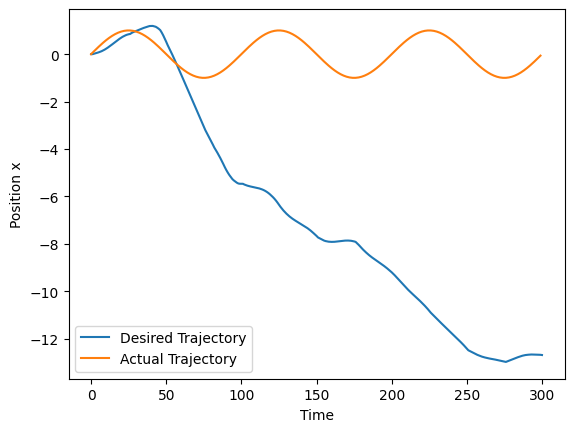

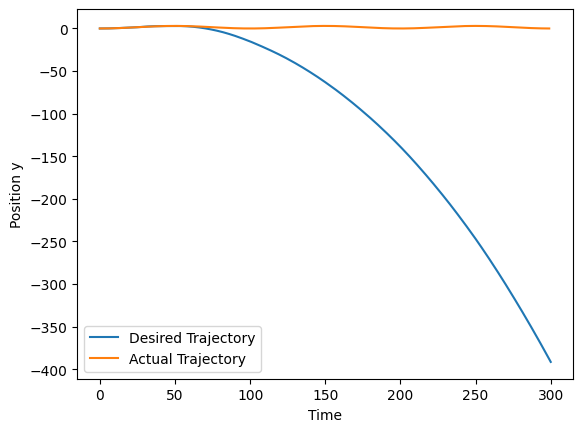

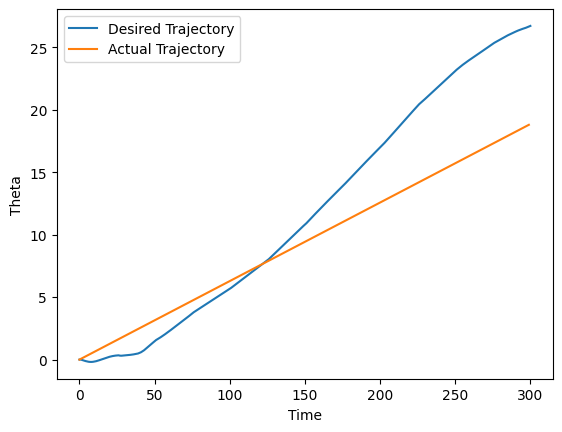

In [8]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(horizon_length)
y_traj = np.zeros(horizon_length)
theta_traj = np.zeros(horizon_length)

for i in range(horizon_length):
    des_x, des_y, des_theta = traj.traj_gen(i, N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(state[0, :], label="Desired Trajectory")
plt.plot(x_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(state[2, :], label="Desired Trajectory")
plt.plot(y_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(state[4, :], label="Desired Trajectory")
plt.plot(theta_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()



